In [1]:
from sklearn import cross_validation, grid_search, linear_model,svm, metrics,preprocessing,pipeline
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import numpy as np
import pandas as pd
import re
# будем отображать графики прямо в jupyter'e
%pylab inline
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

C:\Users\Evtisov_SS\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\Evtisov_SS\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Populating the interactive namespace from numpy and matplotlib


## Raw data

In [2]:
train_df = pd.read_csv('train.csv', header = 0, sep = ',')
test_df = pd.read_csv('test.csv', header = 0, sep = ',')
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Feature Engineering
№ | Код | Название | Примечание
  ------------- | ------------- | -------------
1 | survival | выжил   | 0 = Нет, 1 = Да
2 | pclass  | Класс билета| 1,2,3
3 | sex	| Пол |	male, female
4|Age| Возраст в годах |
5|sibsp	| Количество братьев, сестер, супруг на борту Титаника |
6|parch | Количество родилетей/детей на борту Титаника |
7|ticket | # билета |
8|fare | Стоимость билета |
9|cabin | № каюты |
10|embarked	| Порт посадки | C = Cherbourg, Q = Queenstown, S = Southampton

In [3]:
train_df = train_df.drop(['PassengerId','Ticket'], axis=1)
test_df = test_df.drop(['Ticket'], axis=1)
train_df.head(5)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,NaN,S


### 1. Каюта

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,8,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,2,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,8,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,2,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,8,S


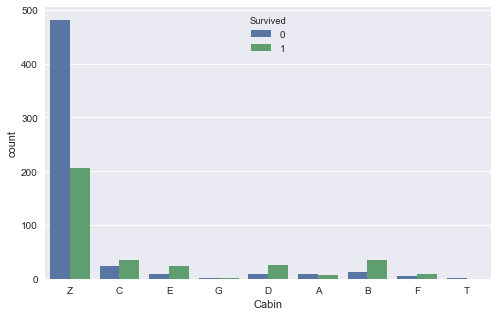

In [4]:
def eng_Cabin(df,plot):
    labelEnc=LabelEncoder()
    df['Cabin']=df['Cabin'].fillna('Z')
    df['Cabin']=df['Cabin'].apply(lambda x:x[0])
    if plot:
        sns.countplot(x='Cabin', hue='Survived', data=df);
    df['Cabin']=labelEnc.fit_transform(df['Cabin'])
    return df

train_df=eng_Cabin(train_df,True)
test_df=eng_Cabin(test_df,False)
train_df.head(5)




### 2.Класс

,Survived,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Class_1,Class_2,Class_3
0,0,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,8,S,0,0,1
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,2,C,1,0,0
2,1,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,8,S,0,0,1
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,2,S,1,0,0
4,0,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,8,S,0,0,1


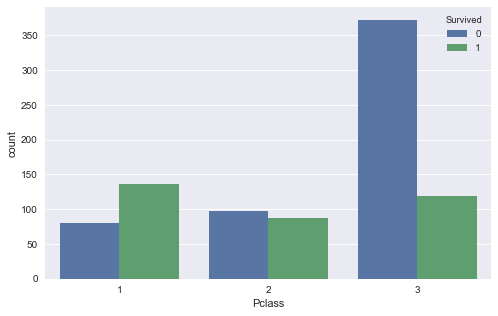

In [5]:
def eng_Class(df,plot):
    if plot: sns.countplot(x='Pclass', hue='Survived', data=df);
    dummies=pd.get_dummies(df['Pclass'])
    dummies.columns = ['Class_1','Class_2','Class_3']
    df=df.join(dummies)
    df.drop(['Pclass'], axis=1,inplace=True)
    return df

train_df=eng_Class(train_df,True)
test_df=eng_Class(test_df,False)
train_df.head(5)

### 3.Возраст

#### Пробуем добораться возраст по полу
df_age=raw_data[['Sex','Age']]
male_age_mean=df_age[df_age['Sex']=='male']['Age'].mean()
female_age_mean=df_age[df_age['Sex']=='female']['Age'].mean()
df_age_male=df_age[df_age['Sex']=='male'][['Age']].fillna(male_age_mean)
df_age_female=df_age[df_age['Sex']=='female'][['Age']].fillna(female_age_mean)
df_age=df_age_male.append(df_age_female)
df_age=df_age.sort_index()


,Survived,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Class_1,Class_2,Class_3,Age0,Age1,Age2,Age3,Age4,Age5,Age6,Age7
0,0,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,8,S,0,0,1,0,0,0,1,0,0,0,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,2,C,1,0,0,0,0,0,0,0,0,1,0
2,1,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,8,S,0,0,1,0,0,0,0,1,0,0,0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,2,S,1,0,0,0,0,0,0,0,1,0,0
4,0,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,8,S,0,0,1,0,0,0,0,0,1,0,0


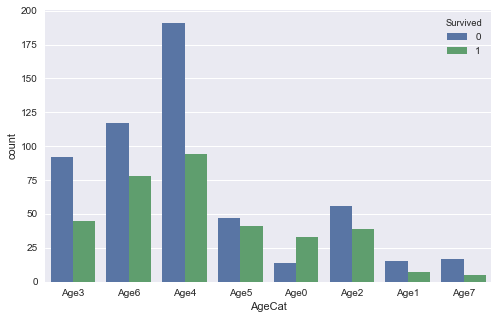

In [6]:
def age_convert(age):
    if age<=6:
        return 0
    elif age<=12:
        return 1
    elif age<=19:
        return 2
    elif age<=25:
        return 3
    elif age<=30:
        return 4
    elif age<=35:
        return 5
    elif age<=60:
        return 6
    else: 
        return 7
    
def eng_Age(df,plot):  
    df['Age']=df['Age'].fillna(df['Age'].mean())
    df['AgeCat']=df['Age'].apply(age_convert)
    df['AgeCat']=df['AgeCat'].apply(lambda x:'Age'+str(x))
    if plot: sns.countplot(x='AgeCat', hue='Survived', data=df);
    # Делаем массив бинарных признаков
    dummies=pd.get_dummies(df['AgeCat'],prefix='',prefix_sep='')
    df=df.join(dummies)
    df.drop(['AgeCat'], axis=1,inplace=True)
    return df

train_df=eng_Age(train_df,True)
test_df=eng_Age(test_df,False)
train_df.head(5)

### 4. Порт посадки

,Survived,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Class_1,Class_2,...,Age1,Age2,Age3,Age4,Age5,Age6,Age7,Embarked_C,Embarked_Q,Embarked_S
0,0,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,8,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,2,1,0,...,0,0,0,0,0,1,0,1,0,0
2,1,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,8,0,0,...,0,0,0,1,0,0,0,0,0,1
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,2,1,0,...,0,0,0,0,1,0,0,0,0,1
4,0,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,8,0,0,...,0,0,0,0,1,0,0,0,0,1


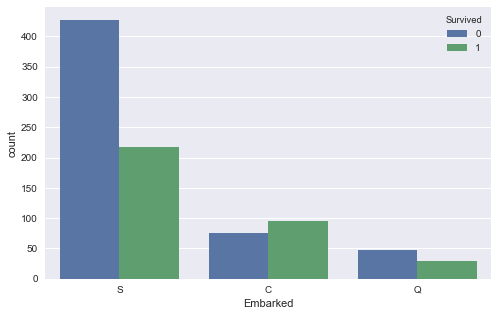

In [7]:
def eng_Emb(df,plot):  
    df['Embarked'].fillna('C',inplace=True)
    if plot:sns.countplot(x='Embarked', hue='Survived', data=df);
    dummies=pd.get_dummies(df['Embarked'],prefix='Embarked')
    df=df.join(dummies)
    df.drop(['Embarked'], axis=1,inplace=True)
    return df

train_df=eng_Emb(train_df,True)
test_df=eng_Emb(test_df,False)
train_df.head(5)

### 5. Семья

,Survived,Name,Sex,Age,Fare,Cabin,Class_1,Class_2,Class_3,Age0,...,Age2,Age3,Age4,Age5,Age6,Age7,Embarked_C,Embarked_Q,Embarked_S,Family
0,0,"Braund, Mr. Owen Harris",male,22.0,7.2500,8,0,0,1,0,...,0,1,0,0,0,0,0,0,1,1
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,71.2833,2,1,0,0,0,...,0,0,0,0,1,0,1,0,0,1
2,1,"Heikkinen, Miss. Laina",female,26.0,7.9250,8,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,53.1000,2,1,0,0,0,...,0,0,0,1,0,0,0,0,1,1
4,0,"Allen, Mr. William Henry",male,35.0,8.0500,8,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0


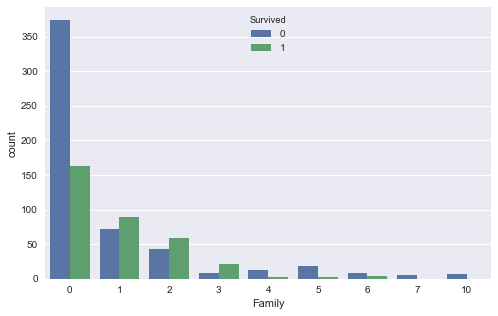

In [8]:
def eng_Family(df,plot):  
    df['Family']=df["SibSp"]+df["Parch"]
    df.drop(['SibSp','Parch'],axis=1,inplace=True)
    if plot:sns.countplot(x='Family', hue='Survived', data=df);
    return df

train_df=eng_Family(train_df,True)
test_df=eng_Family(test_df,False)
train_df.head(5)

### 6.Title

,Survived,Sex,Age,Fare,Cabin,Class_1,Class_2,Class_3,Age0,Age1,...,Age7,Embarked_C,Embarked_Q,Embarked_S,Family,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0,male,22.0,7.2500,8,0,0,1,0,0,...,0,0,0,1,1,0,0,1,0,0
1,1,female,38.0,71.2833,2,1,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
2,1,female,26.0,7.9250,8,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
3,1,female,35.0,53.1000,2,1,0,0,0,0,...,0,0,0,1,1,0,0,0,1,0
4,0,male,35.0,8.0500,8,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0


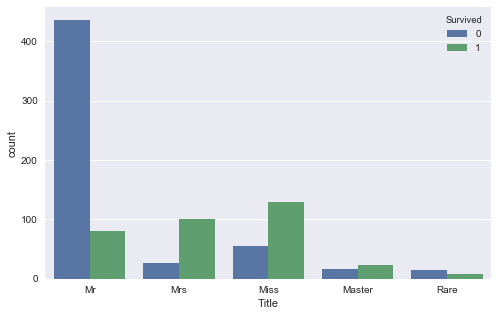

In [9]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""


def eng_Title(df,plot):  
    df['Title']= df['Name'].apply(get_title)
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    if plot:sns.countplot(x='Title', hue='Survived', data=df);
    dummies=pd.get_dummies(df['Title'],prefix='Title')
    df=df.join(dummies)
    df.drop(['Name','Title'], axis=1,inplace=True)
    return df

train_df=eng_Title(train_df,True)
test_df=eng_Title(test_df,False)
train_df.head(5)


### 7. Пол

,Survived,Fare,Cabin,Class_1,Class_2,Class_3,Age0,Age1,Age2,Age3,...,Embarked_S,Family,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Person_child,Person_female,Person_male
0,0,7.2500,8,0,0,1,0,0,0,1,...,1,1,0,0,1,0,0,0,0,1
1,1,71.2833,2,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
2,1,7.9250,8,0,0,1,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
3,1,53.1000,2,1,0,0,0,0,0,0,...,1,1,0,0,0,1,0,0,1,0
4,0,8.0500,8,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1


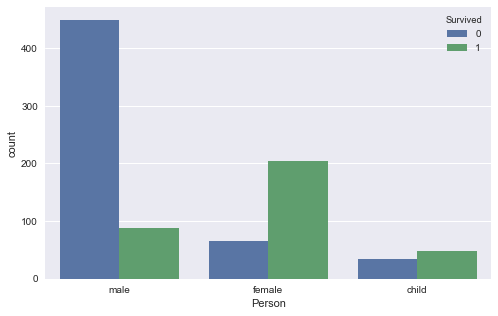

In [10]:
def get_person(passenger):
    age,sex = passenger
    return 'child' if age < 16 else sex

def eng_Sex(df,plot):  
    df['Person'] = df[['Age','Sex']].apply(get_person,axis=1)
    if plot:sns.countplot(x='Person', hue='Survived', data=df);
    dummies=pd.get_dummies(df['Person'],prefix='Person')
    df=df.join(dummies)
    df.drop(['Sex','Age','Person'], axis=1,inplace=True)
    return df

train_df=eng_Sex(train_df,True)
test_df=eng_Sex(test_df,False)
train_df.head(5)

### Fare

In [11]:
def eng_Fare(df,plot):  
    df['Fare']=df['Fare'].fillna(df['Fare'].mean())
    df['Fare']=df['Fare'].apply(lambda x:int(x/20))
    return df

train_df=eng_Fare(train_df,True)
test_df=eng_Fare(test_df,False)
train_df.head(15)

,Survived,Fare,Cabin,Class_1,Class_2,Class_3,Age0,Age1,Age2,Age3,...,Embarked_S,Family,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,Person_child,Person_female,Person_male
0,0,0,8,0,0,1,0,0,0,1,...,1,1,0,0,1,0,0,0,0,1
1,1,3,2,1,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
2,1,0,8,0,0,1,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
3,1,2,2,1,0,0,0,0,0,0,...,1,1,0,0,0,1,0,0,1,0
4,0,0,8,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
5,0,0,8,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
6,0,2,4,1,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
7,0,1,8,0,0,1,1,0,0,0,...,1,4,1,0,0,0,0,1,0,0
8,1,0,8,0,0,1,0,0,0,0,...,1,2,0,0,0,1,0,0,1,0
9,1,1,8,0,1,0,0,0,1,0,...,0,1,0,0,0,1,0,1,0,0


In [20]:
X_train = train_df.drop(['Survived'],axis=1)
y_train = train_df['Survived']
X_test  = test_df.drop("PassengerId",axis=1).copy()

X_train_train,X_train_holdout,y_train_train,y_train_holdout=cross_validation.train_test_split(
    X_train, y_train, test_size=0.33, random_state=1)
print ("X_train=",X_train.shape,X_train_train.shape,X_train_holdout.shape)
print ("y_train=",y_train.shape,y_train_train.shape,y_train_holdout.shape)

X_train= (891, 25) (596, 25) (295, 25)
y_train= (891,) (596,) (295,)


### Модели

In [147]:
def score_model(name,estimator,cv_strategy,fit):
    #создаем pipeline из двух шагов: scaling и классификация
    #est = pipeline.Pipeline(steps = [('scaling', preprocessing.StandardScaler(with_mean = 0)), ('regression', regressor)])
    # Обучение на train, выводим точность классификатора на отложенном тесте
    if fit: estimator.fit(X_train_train, y_train_train)
    predictions=estimator.predict(X_train_holdout)
    acc_score=metrics.accuracy_score(y_train_holdout,predictions)
    f1_score= metrics.f1_score(y_train_holdout, predictions)
    roc_auc_score=metrics.roc_auc_score(y_train_holdout, predictions)
    prc_auc_score=metrics.average_precision_score(y_train_holdout, predictions)
    # Точность на кросс валидации (на полном тесте)
    cv_scoring = cross_validation.cross_val_score(estimator, X_train, y_train, scoring = 'accuracy', cv = cv_strategy)
    return name,round(cv_scoring.mean(),3),round(acc_score,3),round(f1_score,3),round(roc_auc_score,3),round(prc_auc_score,3),

def rank_models(models,fit=True):
    cv_strategy = cross_validation.StratifiedShuffleSplit(y_train, n_iter = 10 , test_size = 0.33, random_state = 1)
    result=pd.DataFrame(columns=['Name',"CV_acc","acc","f1","roc_auc","prc_auc"])
    for model in models:
        score=score_model(model[0],model[1],cv_strategy,fit)
        result.loc[len(result)]=score
    result['CV_Rank'] = result['CV_acc'].rank(ascending=0)    
    result['Acc_Rank'] = result['acc'].rank(ascending=0)    
    result['f1_Rank'] = result['f1'].rank(ascending=0)    
    result['roc_auc_Rank'] = result['roc_auc'].rank(ascending=0)    
    result['prc_auc_Rank'] = result['prc_auc'].rank(ascending=0)   
    result['Rank_score']=result[['CV_Rank','Acc_Rank','f1_Rank','roc_auc_Rank','prc_auc_Rank']].sum(axis=1)
    return result

In [148]:
models=(
        ("LinearLogisticRegression",linear_model.LogisticRegression(random_state = 1)),
        ("LinearRidgeClassifier",linear_model.RidgeClassifier(random_state = 1)),
        ("LinearSVC",svm.LinearSVC(random_state=1)),
        ("NuSVC",svm.NuSVC(random_state=1)),
        ("SVC-rbf",svm.SVC(kernel='rbf',random_state=1)),
        ("SVC-sigmoid",svm.SVC(kernel='sigmoid',random_state=1)),
        ("SVC-poly",svm.SVC(kernel='poly',random_state=1)),   
        ("RandomForestClassifier",RandomForestClassifier(n_estimators=10))
        # ("RandomForestClassifier",RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)) 
)

all_models_score=rank_models(models)
all_models_score.sort_values(by='CV_acc',  ascending=False)

,Name,CV_acc,acc,f1,roc_auc,prc_auc,CV_Rank,Acc_Rank,f1_Rank,roc_auc_Rank,prc_auc_Rank,Rank_score
4,SVC-rbf,0.831,0.790,0.723,0.771,0.796,1.0,2.0,3.5,3.5,1.5,11.5
3,NuSVC,0.829,0.786,0.722,0.770,0.792,2.0,4.5,5.0,5.0,4.5,21.0
0,LinearLogisticRegression,0.827,0.790,0.728,0.774,0.795,3.0,2.0,2.0,2.0,3.0,12.0
1,LinearRidgeClassifier,0.824,0.790,0.723,0.771,0.796,4.0,2.0,3.5,3.5,1.5,14.5
2,LinearSVC,0.822,0.783,0.717,0.766,0.788,5.0,6.0,6.0,6.0,6.0,29.0
6,SVC-poly,0.813,0.786,0.734,0.776,0.792,6.0,4.5,1.0,1.0,4.5,17.0
7,RandomForestClassifier,0.807,0.749,0.657,0.724,0.752,7.0,7.0,7.0,7.0,7.0,35.0
5,SVC-sigmoid,0.621,0.580,0.466,0.559,0.580,8.0,8.0,8.0,8.0,8.0,40.0


## Подбор параметров

In [170]:
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

TypeError: __init__() got an unexpected keyword argument 'n_splits'

### SVC-rbf

In [48]:
# Параметры
param_grid = {"C": np.logspace(-2, 10, 13),
              "gamma": np.logspace(-9, 3, 13)}
est=svm.SVC(kernel='rbf',random_state=1)
grid = GridSearchCV(estimator=est, param_grid=param_grid, cv=cv)
grid.fit(X_train_train, y_train_train)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'C': 10.0, 'gamma': 0.01} with a score of 0.85


SVC(C=10.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=1, shrinking=True,
  tol=0.001, verbose=False)

In [160]:
grid.cv_results_['rank_test_score']<=5

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [164]:
#result.sort_values(by='CV_acc',  ascending=False)
best_est=pd.DataFrame(grid.cv_results_)
best_est=best_est[best_est['rank_test_score']<=5]
best_est=best_est[['params','rank_test_score']].as_matrix()
best_est_list=list()
for i in range(len(best_est)):
    params=best_est[i,0]
    num=best_est[i,1]
    param_C=params['C']
    param_gamma=params['gamma']
    best_est_list.append(('SVC_rbf_'+str(num),svm.SVC(kernel='rbf',random_state=1,gamma=param_gamma,C=param_C)))
svc_models_score=rank_models(best_est_list,True)
all_models_score=all_models_score.append(svc_models_score)
all_models_score.sort_values(by='CV_acc',  ascending=False)

,Name,CV_acc,acc,f1,roc_auc,prc_auc,CV_Rank,Acc_Rank,f1_Rank,roc_auc_Rank,prc_auc_Rank,Rank_score
1,SVC_rbf_3,0.838,0.800,0.735,0.781,0.807,1.0,1.5,1.5,1.5,1.5,7.0
0,SVC_rbf_1,0.837,0.793,0.726,0.774,0.800,2.5,3.0,3.0,3.0,3.0,14.5
3,SVC_rbf_2,0.837,0.800,0.735,0.781,0.807,2.5,1.5,1.5,1.5,1.5,8.5
4,SVC-rbf,0.831,0.790,0.723,0.771,0.796,1.0,2.0,3.5,3.5,1.5,11.5
4,SVC_rbf_4,0.831,0.780,0.716,0.764,0.785,4.0,5.0,4.0,5.0,5.0,23.0
3,NuSVC,0.829,0.786,0.722,0.770,0.792,2.0,4.5,5.0,5.0,4.5,21.0
0,LinearLogisticRegression,0.827,0.790,0.728,0.774,0.795,3.0,2.0,2.0,2.0,3.0,12.0
1,LinearRidgeClassifier,0.824,0.790,0.723,0.771,0.796,4.0,2.0,3.5,3.5,1.5,14.5
2,LinearSVC,0.822,0.783,0.717,0.766,0.788,5.0,6.0,6.0,6.0,6.0,29.0
2,SVC_rbf_4,0.815,0.786,0.715,0.766,0.793,5.0,4.0,5.0,4.0,4.0,22.0


### LinearLogisticRegression 

In [171]:
# Параметры
linlog_param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              "penalty": ['l1','l2']}
linlog_grid = GridSearchCV(linear_model.LogisticRegression(random_state = 1), param_grid=linlog_param_grid, cv=10)
linlog_grid.fit(X_train_train, y_train_train)
print("The best parameters are %s with a score of %0.2f"
 % (linlog_grid.best_params_, linlog_grid.best_score_))

The best parameters are {'C': 0.1, 'penalty': 'l2'} with a score of 0.85


In [176]:
def get_models(name,grid):
    best_est=pd.DataFrame(grid.cv_results_)
    best_est=best_est[best_est['rank_test_score']<=5]
    best_est=best_est[['params','rank_test_score']].as_matrix()
    best_est_list=list()
    for i in range(len(best_est)):
        params=best_est[i,0]
        num=best_est[i,1]
        param_C=params['C']
        param_penalty=params['penalty']
        best_est_list.append((name+str(num),linear_model.LogisticRegression(random_state=1,penalty=param_penalty,C=param_C)))
    return rank_models(best_est_list,True),best_est_list
    
models,lin_est=get_models('linlog',linlog_grid)
all_models_score=all_models_score.append(models)
all_models_score.sort_values(by='CV_acc',  ascending=False)

,Name,CV_acc,acc,f1,roc_auc,prc_auc,CV_Rank,Acc_Rank,f1_Rank,roc_auc_Rank,prc_auc_Rank,Rank_score
1,SVC_rbf_3,0.838,0.800,0.735,0.781,0.807,1.0,1.5,1.5,1.5,1.5,7.0
0,SVC_rbf_1,0.837,0.793,0.726,0.774,0.800,2.5,3.0,3.0,3.0,3.0,14.5
3,SVC_rbf_2,0.837,0.800,0.735,0.781,0.807,2.5,1.5,1.5,1.5,1.5,8.5
0,linlog1,0.834,0.803,0.741,0.786,0.810,1.0,1.0,1.0,1.0,1.0,5.0
0,linlog1,0.834,0.803,0.741,0.786,0.810,1.0,1.0,1.0,1.0,1.0,5.0
4,SVC_rbf_4,0.831,0.780,0.716,0.764,0.785,4.0,5.0,4.0,5.0,5.0,23.0
4,SVC-rbf,0.831,0.790,0.723,0.771,0.796,1.0,2.0,3.5,3.5,1.5,11.5
3,NuSVC,0.829,0.786,0.722,0.770,0.792,2.0,4.5,5.0,5.0,4.5,21.0
0,LinearLogisticRegression,0.827,0.790,0.728,0.774,0.795,3.0,2.0,2.0,2.0,3.0,12.0
1,linlog2,0.825,0.793,0.734,0.778,0.799,2.0,2.0,2.0,2.0,2.0,10.0


### RandomForest

In [54]:
# Utility function to report best scores

param_grid = {"max_depth": [3,5,10, None],
              "min_samples_split": [2, 3,10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
             "n_estimators": [10, 25,50,100,200]}
rfc = RandomForestClassifier(n_estimators=20)

In [234]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(train_data, train_labels)
report(CV_rfc.cv_results_)
print (CV_rfc.best_score_,CV_rfc.best_params_)

KeyboardInterrupt: 

In [55]:
random_search = RandomizedSearchCV(rfc, param_distributions=param_grid,
                                   n_iter=30,cv=10,scoring = 'accuracy')

random_search.fit(X_train, y_train)
report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.842 (std: 0.040)
Parameters: {'min_samples_split': 2, 'max_depth': None, 'criterion': 'entropy', 'n_estimators': 50, 'min_samples_leaf': 10, 'bootstrap': False}

Model with rank: 2
Mean validation score: 0.840 (std: 0.043)
Parameters: {'min_samples_split': 10, 'max_depth': None, 'criterion': 'gini', 'n_estimators': 100, 'min_samples_leaf': 1, 'bootstrap': True}

Model with rank: 3
Mean validation score: 0.835 (std: 0.043)
Parameters: {'min_samples_split': 2, 'max_depth': 10, 'criterion': 'entropy', 'n_estimators': 100, 'min_samples_leaf': 3, 'bootstrap': True}

Model with rank: 3
Mean validation score: 0.835 (std: 0.037)
Parameters: {'min_samples_split': 2, 'max_depth': None, 'criterion': 'entropy', 'n_estimators': 10, 'min_samples_leaf': 10, 'bootstrap': False}



In [56]:
est=random_search.best_estimator_
est.fit(split_train_data,split_train_labels)
print (est.score(split_test_data,split_test_labels))
sv_scoring = cross_validation.cross_val_score(est, X_train, y_train, scoring = 'accuracy', cv = 10)
print (round(sv_scoring.mean(),3), round(sv_scoring.max(),2), round(sv_scoring.min(),2), round(sv_scoring.std(),2))
#est.fit(,y_train)
#est.score(X)
#est.fit(split_train_data,split_train_labels)

0.789830508475
0.834 0.9 0.76 0.04


In [261]:
#est=random_search.best_estimator_
#est1=RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
#est=linear_model.LogisticRegression(random_state = 1)
#est.fit(X_train,y_train)
est.fit(split_train_data,split_train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## Предсказываем результат

In [180]:
# SVC best
#est_list
#est=est_list[0][1]
est=lin_est[0][1]
est.fit(X_train,y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [181]:
Y_pred = est.predict(X_test)
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('titanic.csv', index=False)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)